In [5]:
#!pip install -q -U watermark

In [6]:
#!pip install -q -U transformers

In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.26.0

numpy       : 1.19.5
pandas      : 1.3.2
torch       : 1.11.0+cpu
transformers: 4.21.2



In [8]:
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
df_2 = pd.read_csv("comments_training_dataset - Sheet1.csv", index_col="1000")
df = df_2.dropna()
df = df.T
df.pop(450)
df = df.T
df

,comment,Prequalified sentiment,Information,Opinion,Advice,Impression,Progress,Exercise,Body,Video,Length,Reviewer
1000,,,,,,,,,,,,
0,Hello and can I ask you if I can do also other...,-0.894868,0.0,0.0,0.7,0.0,0.0,0.4,0.0,0.0,74,J
1,As a person with Lyme Disease who is chronical...,-0.992691,0.5,0.3,0.9,0.0,0.0,0.4,0.0,0.6,273,J
3,Has anyone lost weight from this? ❤️,-0.997208,0.0,0.0,0.5,0.6,0.0,0.0,0.8,0.0,36,J
4,doing this to start my fourth year of university,0.991657,0.5,0.0,0.0,0.0,0.8,0.0,0.0,0.0,48,J
5,Simply love it thought I was in shape until this,0.999816,0.2,0.8,0.0,0.4,0.2,0.0,0.5,0.0,48,J
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,Mil gracias yoga with ADRIANE!!!,0.730353,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,32,D
2516,So grateful for you and for this daily practic...,0.99983,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,69,D
2517,Thank you ☺️\n\nMy partner and I do it every e...,0.99747,0.6,0.0,0.0,0.7,0.8,0.0,0.7,0.5,245,D


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2510 entries, 0 to 2519
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   comment                 2510 non-null   object
 1   Prequalified sentiment  2510 non-null   object
 2   Information             2510 non-null   object
 3   Opinion                 2510 non-null   object
 4   Advice                  2510 non-null   object
 5   Impression              2510 non-null   object
 6   Progress                2510 non-null   object
 7   Exercise                2510 non-null   object
 8   Body                    2510 non-null   object
 9   Video                   2510 non-null   object
 10  Length                  2510 non-null   object
 11  Reviewer                2510 non-null   object
dtypes: object(12)
memory usage: 254.9+ KB


In [11]:
sentiments = ['Information', 'Opinion', 'Advice', 'Impression', 'Progress', 'Exercise', 'Body', 'Video']

#for i in sentiments:
#  df[i] = (df[i]/2 + 0.5)

In [12]:
df

,comment,Prequalified sentiment,Information,Opinion,Advice,Impression,Progress,Exercise,Body,Video,Length,Reviewer
1000,,,,,,,,,,,,
0,Hello and can I ask you if I can do also other...,-0.894868,0.0,0.0,0.7,0.0,0.0,0.4,0.0,0.0,74,J
1,As a person with Lyme Disease who is chronical...,-0.992691,0.5,0.3,0.9,0.0,0.0,0.4,0.0,0.6,273,J
3,Has anyone lost weight from this? ❤️,-0.997208,0.0,0.0,0.5,0.6,0.0,0.0,0.8,0.0,36,J
4,doing this to start my fourth year of university,0.991657,0.5,0.0,0.0,0.0,0.8,0.0,0.0,0.0,48,J
5,Simply love it thought I was in shape until this,0.999816,0.2,0.8,0.0,0.4,0.2,0.0,0.5,0.0,48,J
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,Mil gracias yoga with ADRIANE!!!,0.730353,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,32,D
2516,So grateful for you and for this daily practic...,0.99983,0.0,0.8,0.0,0.8,0.0,0.0,0.7,0.6,69,D
2517,Thank you ☺️\n\nMy partner and I do it every e...,0.99747,0.6,0.0,0.0,0.7,0.8,0.0,0.7,0.5,245,D


In [13]:
PRE_TRAINED_MODEL_NAME = "dsantistevan/bert-base-cased-bert-yoga-finetuned"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
token_lens = []

for txt in df.comment:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))

c:\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


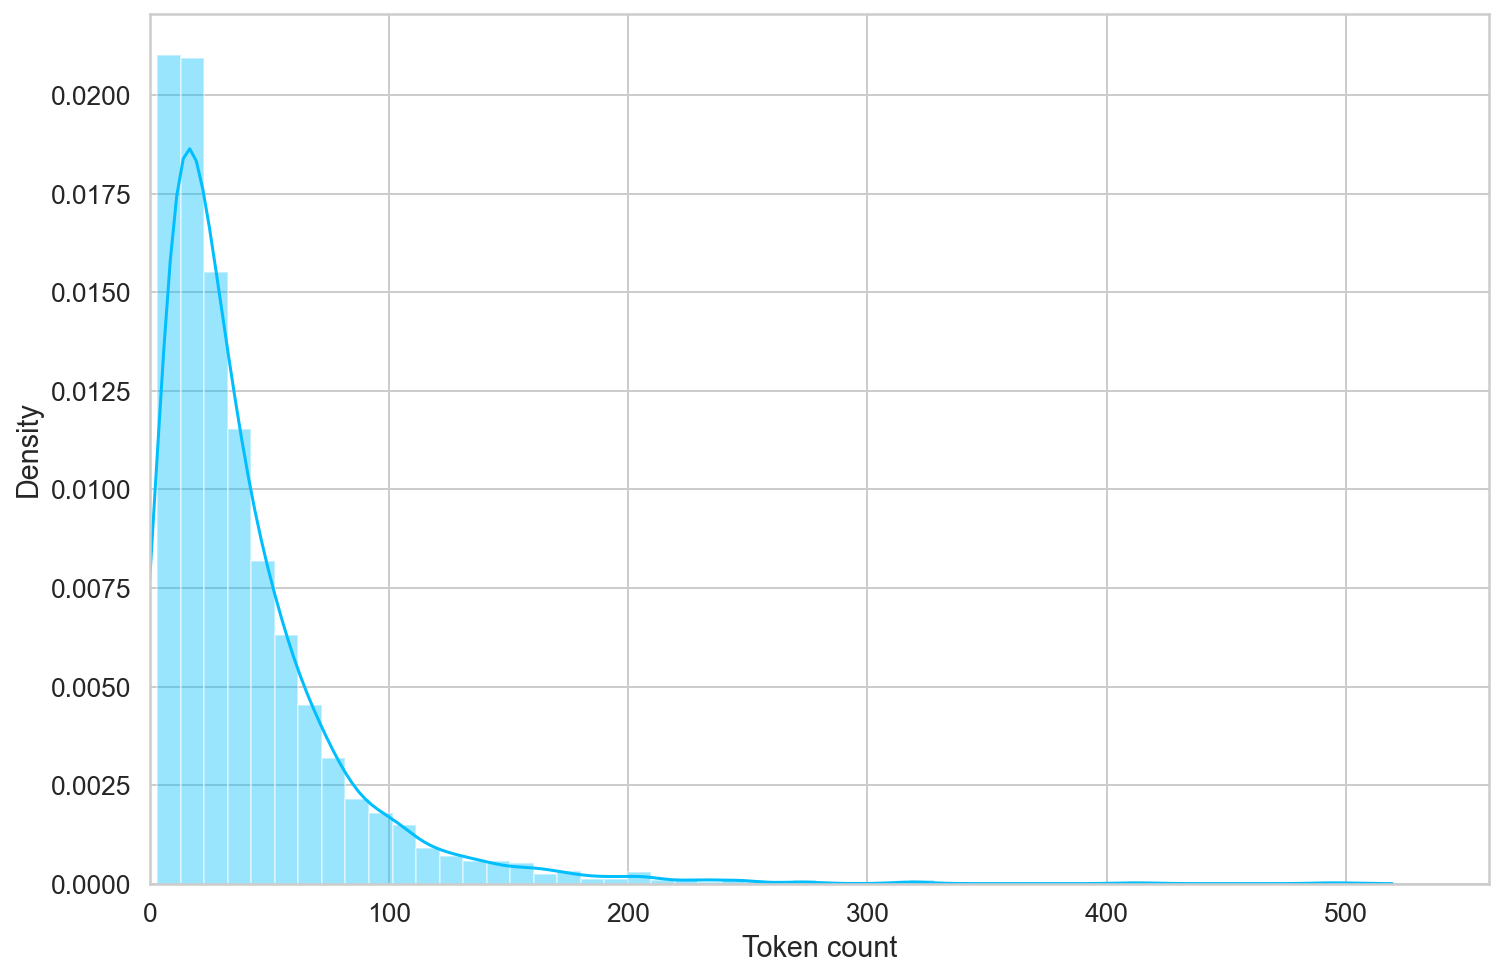

In [16]:
sns.distplot(token_lens)
plt.xlim([0, 560]);
plt.xlabel('Token count');

In [17]:
MAX_LEN = 500

In [18]:
class YTCommentDataset(Dataset):

    def __init__(self, comments, targets, tokenizer, max_len):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.targets[item:item+1]

        encoding = self.tokenizer.encode_plus(
          comment,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'comment_text': comment,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.FloatTensor(list(target))
        }

In [19]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((2008, 12), (251, 12), (251, 12))

In [21]:
sentiment_num = 0

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = YTCommentDataset(
        comments=df.comment.to_numpy(),
        targets=df[sentiments[sentiment_num]].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [23]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:

data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\python39\lib\site-packages\transformers\tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['targets'])

tensor([[ 0.0000],
        [ 0.6000],
        [ 0.5000],
        [ 0.6000],
        [ 0.5000],
        [ 0.4000],
        [ 0.5000],
        [ 0.6000],
        [ 0.4000],
        [ 0.3000],
        [-0.4000],
        [ 0.3000],
        [ 0.0000],
        [ 0.6000],
        [ 0.0000],
        [ 0.4000]])


In [26]:
class SentimentScorer(nn.Module):

    def __init__(self):
        super(SentimentScorer, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )[1]
        output = self.drop(F.relu(pooled_output))
        return self.out(output)

In [28]:
model = SentimentScorer()
model = model.to(device)
model.load_state_dict(torch.load('minus_to_one/best_model_state_{}.bin'.format(sentiments[sentiment_num]), map_location=device))

Some weights of the model checkpoint at dsantistevan/bert-base-cased-bert-yoga-finetuned were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dsantistevan/bert-base-cased-bert-yoga-finetuned and are newly initialized: 

<All keys matched successfully>

In [29]:
bert_params = set()
for param in model.bert.parameters():
    param.requires_grad = False
    bert_params.add(param)

In [30]:

for param in model.parameters():
    if param not in bert_params:
        print(param)

Parameter containing:
tensor([[-8.4047e-03,  7.2830e-03,  8.2251e-05,  2.3300e-02,  6.2166e-03,
         -3.5212e-02,  2.5061e-02,  3.8267e-03,  1.8201e-02, -1.8261e-02,
          2.8886e-02, -5.9718e-03,  2.8388e-02, -3.0028e-02, -2.0527e-02,
         -1.7683e-02,  1.6883e-04,  1.0549e-02,  7.7382e-03,  1.1834e-02,
         -1.3370e-02, -1.3777e-02, -2.0653e-02, -2.5831e-02, -1.0043e-02,
          1.0662e-02,  4.7056e-02,  2.4894e-02,  2.8466e-02,  3.7556e-02,
          1.2643e-03,  1.3084e-02,  1.5324e-02, -2.6040e-02,  2.5556e-02,
         -5.1298e-03, -1.9330e-03, -2.4805e-02,  1.7975e-02,  1.7845e-02,
          2.1918e-02, -2.4970e-02,  4.1681e-02, -1.8392e-02,  2.4834e-02,
          3.1724e-02, -3.4027e-02,  1.1350e-04,  1.6824e-02,  2.1424e-02,
         -3.7959e-02, -2.9954e-02,  1.2366e-02, -1.3658e-02, -2.7369e-02,
          1.6311e-02, -2.5143e-03, -3.0288e-02, -2.1092e-02,  1.6448e-02,
          8.9746e-04, -2.9687e-02,  4.2745e-02,  2.8654e-02, -9.2887e-05,
          1.4320

In [31]:
for i in model.out.parameters():
    print(i.shape)

torch.Size([1, 768])
torch.Size([1])


In [32]:
EPOCHS = 0

optimizer = torch.optim.SGD(model.out.parameters(), lr=0.003)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss().to(device)

In [33]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

            #print(outputs)
            #print(targets)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0
best_loss = float('inf')

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state_{}.bin'.format(sentiments[sentiment_num]))
        best_loss = val_loss

Wall time: 0 ns


In [36]:
sumaa=0
mod = []
tar = []
for i in test_data_loader:
    for j in range(len(i['input_ids'])-1):
        inp = i['input_ids'][j:j+1].to(device)
        att = i['attention_mask'][j:j+1].to(device)
        mod.append(model(input_ids=inp,attention_mask=att).flatten().item())
        tar.append(i['targets'][j].flatten().item())
        

In [42]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [37]:
tar_np = np.array(mod)

In [38]:
normalized = (tar_np - np.min(tar_np)) / (np.max(tar_np) - np.min(tar_np))

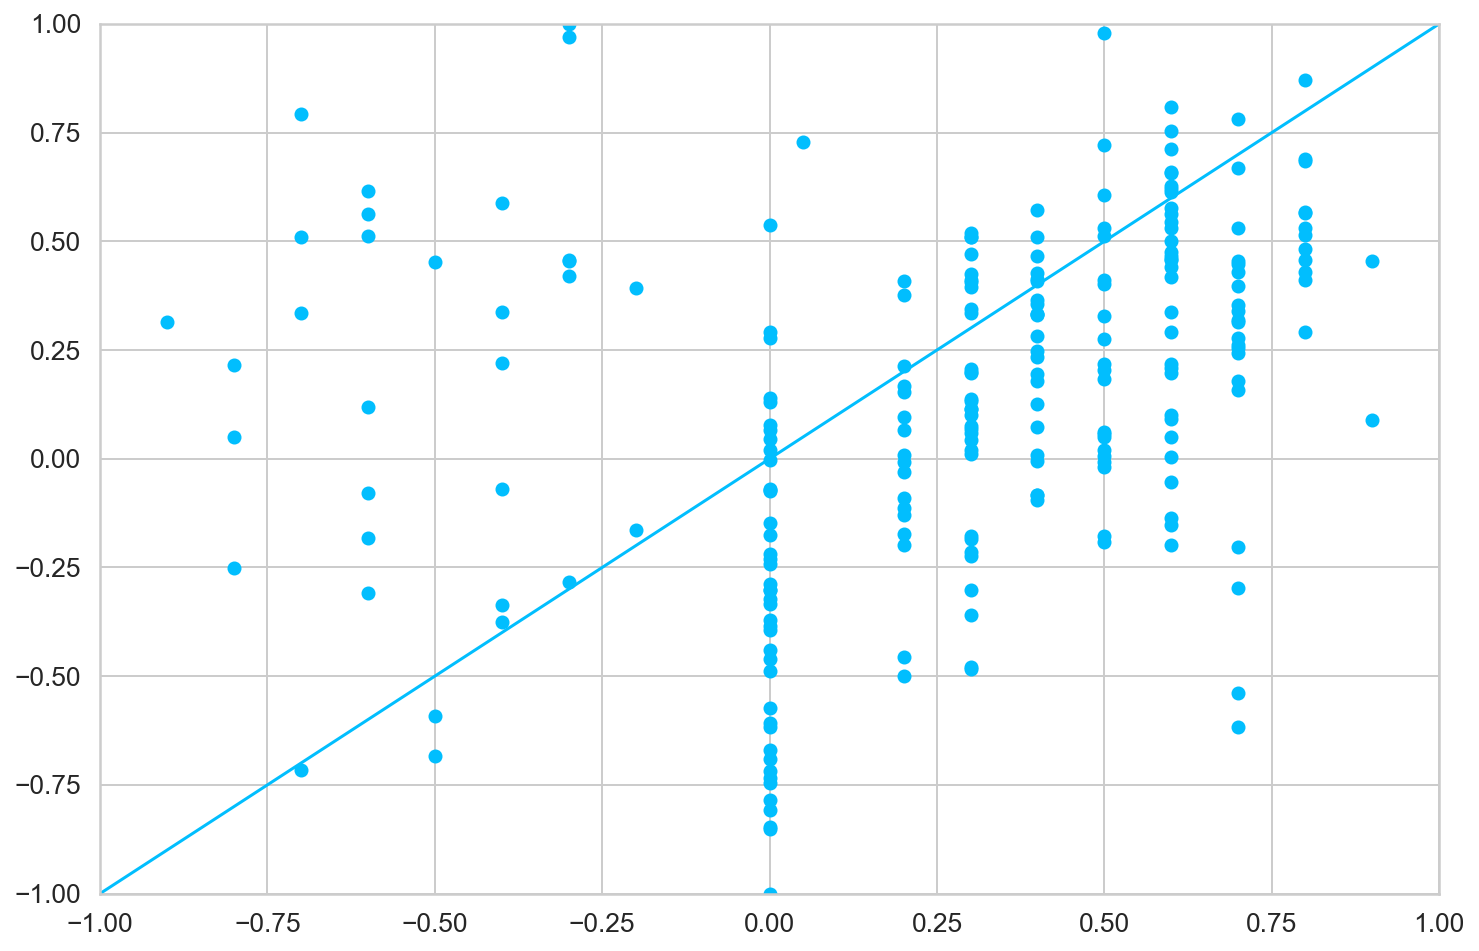

In [39]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(tar,(normalized-0.5)*2)
print(mae(tar, (normalized-0.5)*2))
a = [i/3 for i in range(-3,4)]
plt.plot(a,a)

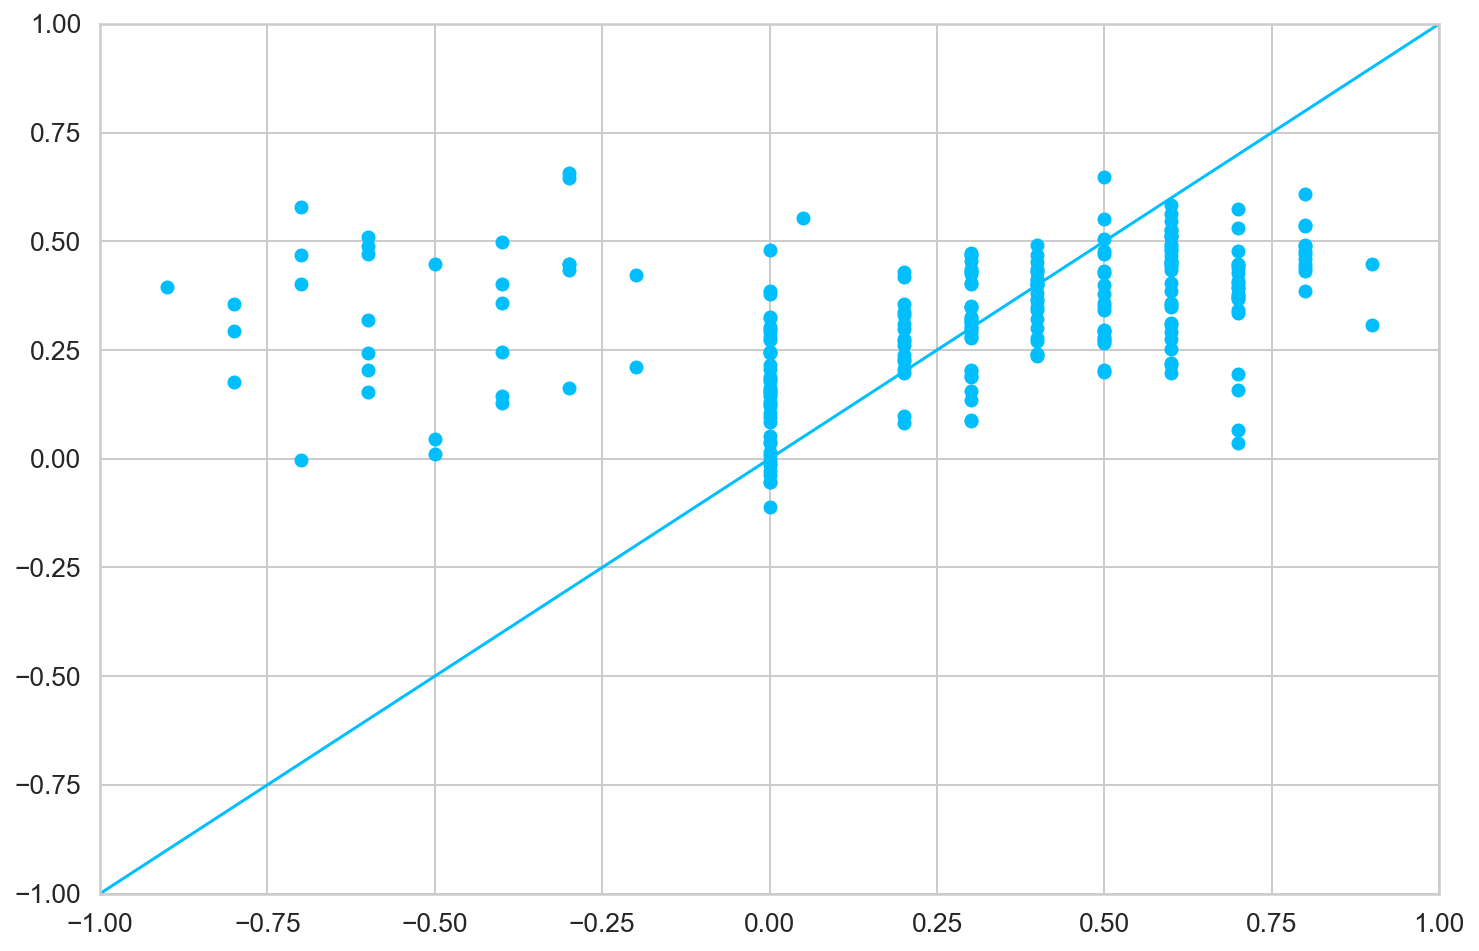

In [40]:
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter(tar,mod)
a = [i/3 for i in range(-3,4)]
plt.plot(a,a)

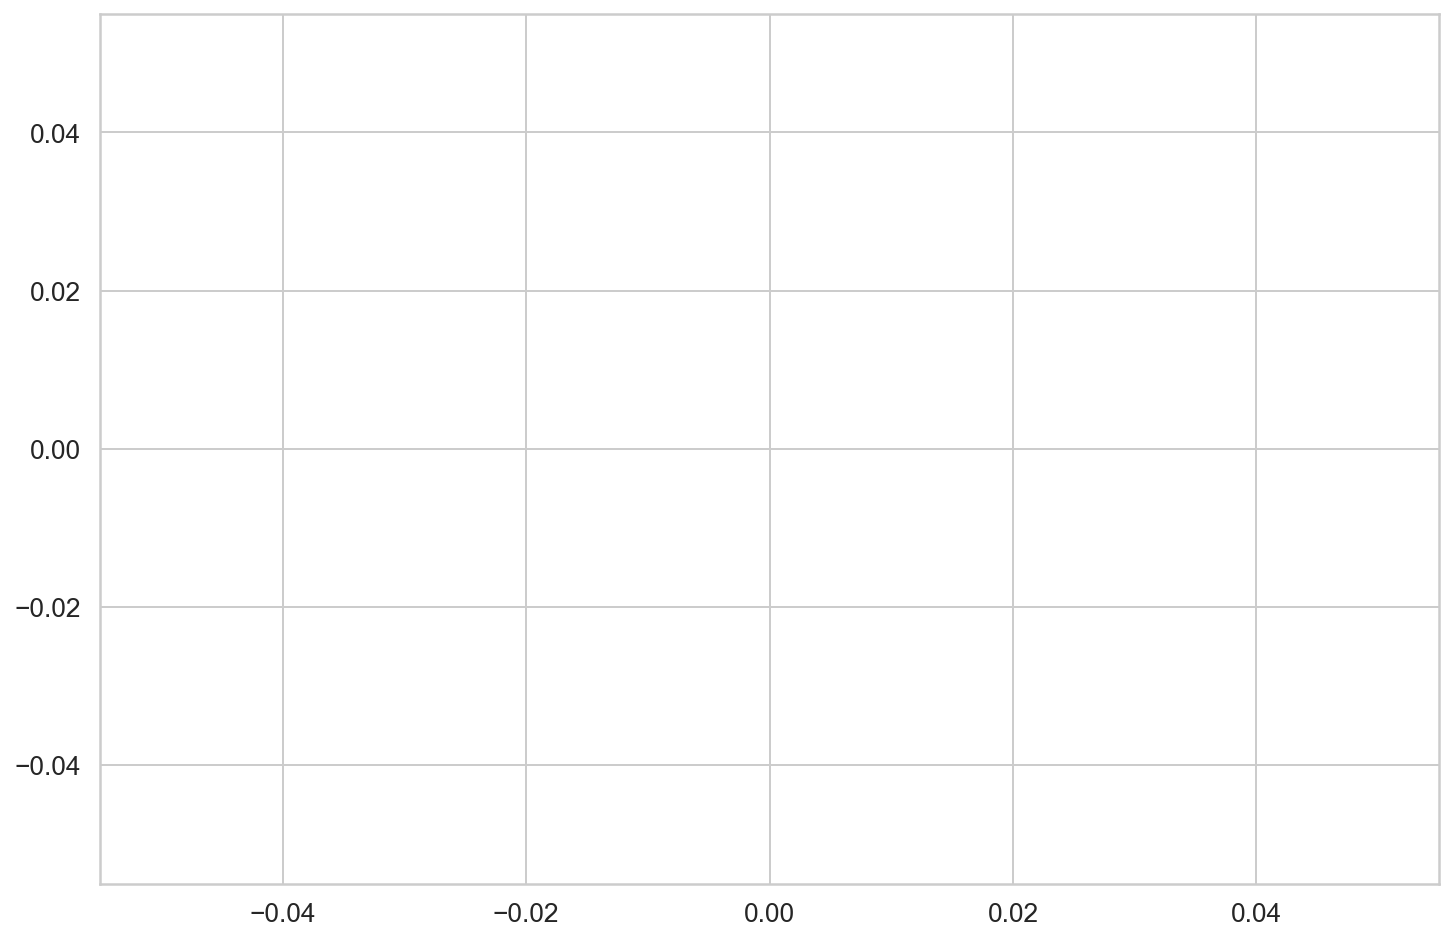

In [41]:
plt.plot(history['val_loss'])
plt.plot(history['train_loss'])

0.37223198714260103